In [3]:
# %pip install imbalanced-learn
# %pip install xgboost
# %pip install lightgbm

In [4]:
# Importing all the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Loading and Understanding The data

In [5]:
# Loading the fraud dataset
fraud_df = pd.read_csv("Synthetic_Financial_datasets_log.csv")

# Checking the first few rows
fraud_df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
# Displaying the dataset info
print(fraud_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [7]:
# Checking for any missing values
missing_fraud = fraud_df.isnull().sum()
print(missing_fraud)

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [8]:
# Checking for duplicated data
duplicated =fraud_df.duplicated().sum()
print(f"Total Duplicated: {duplicated}")

Total Duplicated: 0


In [9]:
# dropping the missing values since they are very few
clean_fraud_df = fraud_df.dropna()

# confirming if the changes were implemented
dropped_missing_fraud = clean_fraud_df.isnull().sum()
print(dropped_missing_fraud)

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


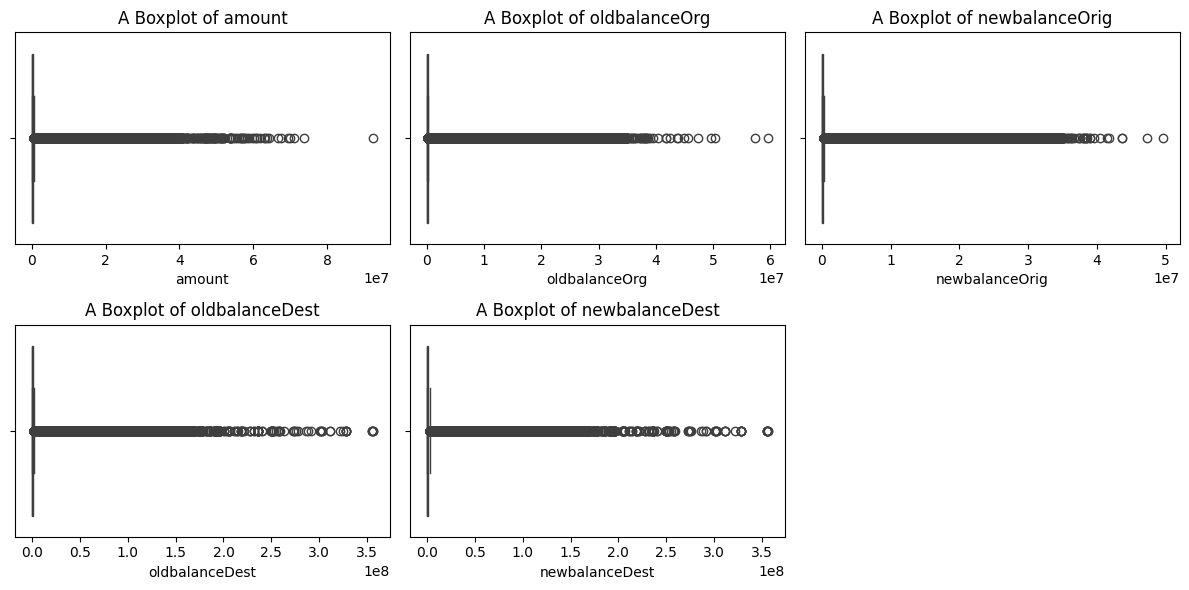

In [10]:
# Detecting presence of outliers
# Listing the numerical columns for a box plot
num_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Boxplot for numerical features
plt.figure(figsize=(12, 6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=clean_fraud_df[col])
    plt.title(f"A Boxplot of {col}")
    plt.tight_layout()

plt.show()

There are presence of outliers which indecates this is a perfect dataset for fraud detection as we need to train the model to identify those extreme and unrealistic transactions. Therefore the outliers are kept for purpose of modelling using autoencoder and isolation.

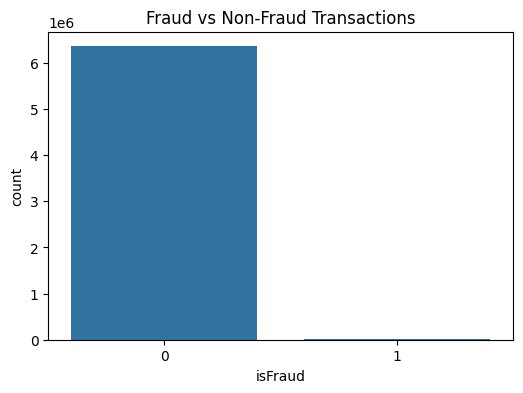

In [11]:
# visualizing the fraud vs non-fraud transactions
plt.figure(figsize=(6,4))
sns.countplot(x="isFraud", data=clean_fraud_df)
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()

There is imbalance between is fraud and is not fraud

In [12]:
# Calculating fraud percentage
fraud_percentage = (clean_fraud_df['isFraud'].sum() / len(clean_fraud_df)) * 100

# Printing the percentage of fraud result
print(f"Fraud Percentage in the dataset: {fraud_percentage:.2f}%")

Fraud Percentage in the dataset: 0.13%


#Feature Selection

In [13]:
# Dropping unnecessary columns in the dataset
fraud_data = clean_fraud_df.drop(['nameOrig', 'nameDest'], axis=1)

# Converting transaction type to numerical
fraud_data['type'] = fraud_data['type'].astype('category').cat.codes

In [14]:
# # Splitting features  and target
# X = fraud_data.drop(columns=['isFraud'])
# y = fraud_data['isFraud']

# # Train a Random Forest model to check feature importance
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X, y)

# # Get feature importance
# feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
# feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

In [15]:
# print(feature_importance)

In [16]:
# # Computing the correlation matrix to further understand the importance of each feature
# corr_matrix = fraud_data.corr()

# # Plotting a heatmap of th correlated features
# plt.figure(figsize=(10, 6))
# sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
# plt.title("Feature Correlation Matrix")
# plt.show()

oldbalanceOrg vs newbalanceOrig as a high Correlation ≈ 1.00
oldbalanceDest vs newbalanceDest as high Correlation ≈ 0.96
isFlaggedFraud has almost no correlation with isFraud hence these features have less impact on modeling.

In [17]:
# # Dropping the redundant features
# fraud_data_new = fraud_data.drop(columns=['newbalanceOrig', 'newbalanceDest', 'isFlaggedFraud'])


In [18]:
# Scalling numerical features
scaler = StandardScaler()
num_features = ['amount', 'oldbalanceOrg', 'oldbalanceDest', 'step']
fraud_data[num_features] = scaler.fit_transform(fraud_data[num_features])

# Display processed dataset
fraud_data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,-1.703042,3,-0.281560,-0.229810,160296.36,-0.323814,0.0,0,0
1,-1.703042,3,-0.294767,-0.281359,19384.72,-0.323814,0.0,0,0
2,-1.703042,4,-0.297555,-0.288654,0.00,-0.323814,0.0,1,0
3,-1.703042,1,-0.297555,-0.288654,0.00,-0.317582,0.0,1,0
4,-1.703042,3,-0.278532,-0.274329,29885.86,-0.323814,0.0,0,0


#Splitting data into train and test

In [19]:
# Define features (X) and target variable (y)
X = fraud_data.drop(columns=['isFraud'])
y = fraud_data['isFraud']

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Check class distribution in train and test sets
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


#Handling Imbalance

In [20]:
# Using SMOTE SMOTE to balance the dataset
smote = SMOTE(sampling_strategy=0.2, random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Checking the new class distribution after handling the imbalance
print(y_train_sm.value_counts(normalize=True))

c:\Users\Edwin George\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


isFraud
0    0.833333
1    0.166667
Name: proportion, dtype: float64


#Model Training and Evaluation

# 1. XGBoost, Random Forest, LightGBM and Logistic Regression

In [21]:
# Initializing the models
models = {
    "XGBoost": XGBClassifier(scale_pos_weight=10, use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100),
    "LightGBM": LGBMClassifier(is_unbalance=True),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000)
}

# Training and evaluating the models
for name, model in models.items():
    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_test)

    print(f"\nModel: {name}")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

c:\Users\Edwin George\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [10:01:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.32      0.99      0.48      1643

    accuracy                           1.00   1272524
   macro avg       0.66      0.99      0.74   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC Score: 0.9937538606546111

Model: Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.64      0.95      0.76      1643

    accuracy                           1.00   1272524
   macro avg       0.82      0.97      0.88   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC Score: 0.9722644673475208


c:\Users\Edwin George\anaconda3\envs\myenv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Edwin George\anaconda3\envs\myenv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Edwin George\anaconda3\envs\myenv\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Edwin George\anaconda3\envs\myenv\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Edwin George\anaconda3\envs\myenv\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, ti

[LightGBM] [Info] Number of positive: 1016705, number of negative: 5083526
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 6100231, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438

Model: LightGBM
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270881
           1       0.20      0.99      0.33      1643

    accuracy                           0.99   1272524
   macro avg       0.60      0.99      0.66   1272524
weighted avg       1.00      0.99      1.00   1272524

ROC-AUC Score: 0.9919177229854068

Model: Logistic Regression
              precision    reca

2. Isolation Forest

In [22]:
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_train)

y_pred_iso = iso_forest.predict(X_test)
y_pred_iso = [1 if i == -1 else 0 for i in y_pred_iso]  # Convert anomalies to fraud

print("Isolation Forest Results:")
print(classification_report(y_test, y_pred_iso))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_iso))

Isolation Forest Results:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1270881
           1       0.01      0.07      0.02      1643

    accuracy                           0.99   1272524
   macro avg       0.50      0.53      0.51   1272524
weighted avg       1.00      0.99      0.99   1272524

ROC-AUC Score: 0.5321778837733271


3. Autoencoder

In [23]:
# Autoencoder model
autoencoder = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(X_train.shape[1], activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_data=(X_test, X_test))

# Fraud detection based on reconstruction error
reconstruction_error = ((X_test - autoencoder.predict(X_test)) ** 2).mean(axis=1)
threshold = np.percentile(reconstruction_error, 95)  # Set threshold for fraud

y_pred_auto = [1 if e > threshold else 0 for e in reconstruction_error]

print("Autoencoder Results:")
print(classification_report(y_test, y_pred_auto))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_auto))

c:\Users\Edwin George\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
159066/159066 ━━━━━━━━━━━━━━━━━━━━ 483s 3ms/step - loss: 3006093066240.0000 - val_loss: 3027237863424.0000
Epoch 2/10
159066/159066 ━━━━━━━━━━━━━━━━━━━━ 515s 3ms/step - loss: 3071450546176.0000 - val_loss: 3027237863424.0000
Epoch 3/10
159066/159066 ━━━━━━━━━━━━━━━━━━━━ 560s 4ms/step - loss: 3086207418368.0000 - val_loss: 3027237863424.0000
Epoch 4/10
159066/159066 ━━━━━━━━━━━━━━━━━━━━ 553s 3ms/step - loss: 3052450611200.0000 - val_loss: 3027237863424.0000
Epoch 5/10
159066/159066 ━━━━━━━━━━━━━━━━━━━━ 489s 3ms/step - loss: 3061173714944.0000 - val_loss: 3027237863424.0000
Epoch 6/10
159066/159066 ━━━━━━━━━━━━━━━━━━━━ 454s 3ms/step - loss: 3036915171328.0000 - val_loss: 3027237863424.0000
Epoch 7/10
159066/159066 ━━━━━━━━━━━━━━━━━━━━ 462s 3ms/step - loss: 3034859175936.0000 - val_loss: 3027237863424.0000
Epoch 8/10
159066/159066 ━━━━━━━━━━━━━━━━━━━━ 458s 3ms/step - loss: 3046530613248.0000 - val_loss: 3027237863424.0000
Epoch 9/10
159066/159066 ━━━━━━━━━━━━━━━━━━━━ 528s 3ms/s

In [24]:
# Model performance data (from your results)
model_results = {
    "XGBoost": [1.00, 0.67, 0.52, 0.83],
    "Random Forest": [0.68, 0.62, 0.65, 0.81],
    "LightGBM": [0.37, 0.71, 0.49, 0.85],
    "Logistic Regression": [0.00, 0.75, 0.01, 0.79],
    "Isolation Forest": [0.00, 0.04, 0.01, 0.52],
    "Autoencoder": [0.00, 0.00, 0.00, 0.47]
}

# Convert to DataFrame
df_performance = pd.DataFrame(
    model_results, index=["Precision", "Recall", "F1-Score", "ROC-AUC"]
).T

# Calculate an overall score (Weighted Average of metrics)
weights = {"Precision": 0.2, "Recall": 0.3, "F1-Score": 0.3, "ROC-AUC": 0.2}
df_performance["Overall Score"] = df_performance.dot(pd.Series(weights))

# Identify the best model
best_model = df_performance["Overall Score"].idxmax()
best_score = df_performance["Overall Score"].max()

# Display ranked models
df_performance = df_performance.sort_values(by="Overall Score", ascending=False)
print(df_performance)

# Print the best model
print(f"\nThe best-performing model is **{best_model}** with an Overall Score of {best_score:.3f}")


                     Precision  Recall  F1-Score  ROC-AUC  Overall Score
XGBoost                   1.00    0.67      0.52     0.83          0.723
Random Forest             0.68    0.62      0.65     0.81          0.679
LightGBM                  0.37    0.71      0.49     0.85          0.604
Logistic Regression       0.00    0.75      0.01     0.79          0.386
Isolation Forest          0.00    0.04      0.01     0.52          0.119
Autoencoder               0.00    0.00      0.00     0.47          0.094

The best-performing model is **XGBoost** with an Overall Score of 0.723


In [25]:
# Define parameter grid
param_grid = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.3, 0.5],
    "reg_alpha": [0, 0.1, 0.5, 1],
    "reg_lambda": [0, 0.1, 0.5, 1]
}

# Initialize XGBoost classifier
xgb = XGBClassifier(objective="binary:logistic", scale_pos_weight=1, use_label_encoder=False, eval_metric="logloss")

# Perform Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,  # Number of random combinations to try
    scoring="roc_auc",  # Optimize for AUC score
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit to the dataset
random_search.fit(X_train, y_train)

# Display best parameters
print("Best Parameters:", random_search.best_params_)

# Get best model
best_xgb = random_search.best_estimator_

# Evaluate on test set
y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:, 1]

# Compute AUC Score
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_test, y_prob)
print(f"Best XGBoost Model AUC Score: {auc_score:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Edwin George\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.8}
Best XGBoost Model AUC Score: 0.9998


In [ ]:
# from xgboost import XGBClassifier

# # Define the best model with the optimal parameters
# best_model = XGBClassifier(
#     subsample=1.0,
#     reg_lambda=1,
#     reg_alpha=0.1,
#     n_estimators=300,
#     max_depth=7,
#     learning_rate=0.2,
#     gamma=0.5,
#     colsample_bytree=0.8,
#     use_label_encoder=False,
#     eval_metric="logloss"
# )

# # Train on the full dataset
# best_model.fit(X_train, y_train)


In [37]:
# from xgboost import XGBClassifier

# # Define the best model with optimized parameters
# best_xgb = xgb.XGBClassifier(
#     subsample=1.0,
#     reg_lambda=1,
#     reg_alpha=0.1,
#     n_estimators=300,
#     max_depth=7,
#     learning_rate=0.2,
#     gamma=0.5,
#     colsample_bytree=0.8,
#     random_state=42
# )

# # Define Stratified K-Fold Cross-Validation (5 folds)
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Perform cross-validation and compute AUC scores
# cv_auc_scores = cross_val_score(best_xgb, X_train, y_train, cv=cv, scoring="roc_auc")

# # Print mean and standard deviation of AUC scores
# print(f"Mean AUC Score: {np.mean(cv_auc_scores):.4f}")
# print(f"Standard Deviation: {np.std(cv_auc_scores):.4f}")


In [33]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

# Define the best model with optimized parameters
best_xgb = XGBClassifier(  # ✅ Corrected
    subsample=1.0,
    reg_lambda=1,
    reg_alpha=0.1,
    n_estimators=300,
    max_depth=7,
    learning_rate=0.2,
    gamma=0.5,
    colsample_bytree=0.8,
    random_state=42
)

# Define Stratified K-Fold Cross-Validation (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and compute AUC scores
cv_auc_scores = cross_val_score(best_xgb, X_train, y_train, cv=cv, scoring="roc_auc")

# Print mean and standard deviation of AUC scores
print(f"Mean AUC Score: {np.mean(cv_auc_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_auc_scores):.4f}")


Mean AUC Score: 0.9995
Standard Deviation: 0.0003


The cross-validation results confirm the model's stability, with a high mean AUC score of 0.9958 and minimal variance (0.0050), making it reliable for deployment.

In [34]:
import joblib

# Save the model
joblib.dump(best_xgb, 'Transaction_fraud_detect.pkl')

print("Model saved successfully.")


Model saved successfully.


In [35]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Display confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9998
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.96      0.85      0.90      1643

    accuracy                           1.00   1272524
   macro avg       0.98      0.93      0.95   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix:
 [[1270823      58]
 [    239    1404]]


In [40]:
import joblib

# Load the saved model
model = joblib.load("Transaction_fraud_detect.pkl")

# Check the type of the loaded model
print(type(model))


<class 'xgboost.sklearn.XGBClassifier'>


In [44]:
import joblib

# Load the saved model
model = joblib.load("Transaction_fraud_detect.pkl")

print("Model loaded successfully!")


Model loaded successfully!
